# Driver Scheduling: Multi-Model Indexing

This notebook demonstrates LumiX's **multi-model indexing** feature - the ability to index variables by multiple data model instances simultaneously using cartesian products. This is **THE KEY FEATURE** that sets LumiX apart from other optimization libraries.

## Problem Description

A delivery company needs to schedule drivers over a week to **minimize labor costs** while:
- Meeting daily coverage requirements (minimum drivers per day)
- Respecting driver availability (days off, max working days)
- Handling overtime pay for weekends

## Mathematical Formulation

**Decision Variables:**
$$x_{d,t} \in \{0, 1\} \quad \text{driver } d \text{ works on date } t$$

**Objective (Minimize Cost):**
$$\min \sum_{d \in \text{Drivers}} \sum_{t \in \text{Dates}} \text{cost}_{d,t} \cdot x_{d,t}$$

**Subject to:**
$$\sum_{t \in \text{Dates}} x_{d,t} \leq \text{max\_days}_d \quad \forall d \in \text{Drivers}$$
$$\sum_{d \in \text{Drivers}} x_{d,t} \geq \text{min\_required}_t \quad \forall t \in \text{Dates}$$

## Key Concepts

- **Multi-model indexing**: Variables indexed by `(Driver, Date)` tuples
- **Cartesian product**: `LXIndexDimension` creates all valid combinations
- **cost_multi()**: Cost functions receiving both index models
- **where_multi()**: Filter combinations based on both models
- **Cross-dimensional constraints**: Sum over specific dimensions

## 1. Setup and Imports

In [1]:
# Standard library
import datetime
from dataclasses import dataclass
from typing import List, Tuple

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

# LumiX optimization library
from lumix import (
    LXConstraint,
    LXIndexDimension,
    LXLinearExpression,
    LXModel,
    LXOptimizer,
    LXVariable,
)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## 2. Data Definition

We define drivers with their availability and costs, and dates with coverage requirements.

In [2]:
@dataclass
class Driver:
    """Represents a delivery driver with availability and cost."""
    id: int
    name: str
    daily_rate: float          # Base $ per day
    max_days_per_week: int     # Maximum working days
    is_active: bool            # Whether available for scheduling
    days_off: List[int]        # Weekday numbers off (0=Mon, 6=Sun)


@dataclass
class Date:
    """Represents a scheduling date with requirements."""
    date: datetime.date
    overtime_multiplier: float  # Cost multiplier (1.5x for weekends)
    min_drivers_required: int   # Minimum coverage
    is_weekend: bool


# Sample drivers
DRIVERS = [
    Driver(id=1, name="Alice", daily_rate=150.0, max_days_per_week=5, 
           is_active=True, days_off=[6]),           # Sunday off
    Driver(id=2, name="Bob", daily_rate=120.0, max_days_per_week=6, 
           is_active=True, days_off=[]),            # Can work any day
    Driver(id=3, name="Charlie", daily_rate=100.0, max_days_per_week=4, 
           is_active=True, days_off=[5, 6]),        # Sat, Sun off
    Driver(id=4, name="Diana", daily_rate=140.0, max_days_per_week=5, 
           is_active=True, days_off=[0]),           # Monday off
    Driver(id=5, name="Eve", daily_rate=110.0, max_days_per_week=3, 
           is_active=True, days_off=[1, 2, 5, 6]),  # Only Wed-Fri
    Driver(id=6, name="Frank", daily_rate=95.0, max_days_per_week=7, 
           is_active=False, days_off=[]),           # INACTIVE
]


def generate_week_dates(start_date: datetime.date) -> List[Date]:
    """Generate a week of scheduling dates."""
    dates = []
    for i in range(7):
        current_date = start_date + datetime.timedelta(days=i)
        is_weekend = current_date.weekday() >= 5
        dates.append(Date(
            date=current_date,
            overtime_multiplier=1.5 if is_weekend else 1.0,
            min_drivers_required=2 if is_weekend else 3,
            is_weekend=is_weekend,
        ))
    return dates


# Week starting Monday, January 6, 2025
START_DATE = datetime.date(2025, 1, 6)
DATES = generate_week_dates(START_DATE)


def is_driver_available(driver: Driver, date: Date) -> bool:
    """Check if driver is available on a specific date."""
    if not driver.is_active:
        return False
    if date.date.weekday() in driver.days_off:
        return False
    return True


def calculate_cost(driver: Driver, date: Date) -> float:
    """Calculate cost of assigning driver to date."""
    return driver.daily_rate * date.overtime_multiplier


print(f"Active drivers: {sum(1 for d in DRIVERS if d.is_active)}")
print(f"Scheduling period: {DATES[0].date} to {DATES[-1].date}")

Active drivers: 5
Scheduling period: 2025-01-06 to 2025-01-12


### Visualize Driver Data

In [3]:
# Create driver summary DataFrame
driver_df = pd.DataFrame([
    {
        'Driver': d.name,
        'Daily Rate ($)': d.daily_rate,
        'Max Days/Week': d.max_days_per_week,
        'Status': 'Active' if d.is_active else 'Inactive',
        'Days Off': ', '.join(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day] for day in d.days_off) or 'None'
    }
    for d in DRIVERS
])

print("Driver Information:")
display(driver_df.set_index('Driver'))

Driver Information:


,Daily Rate ($),Max Days/Week,Status,Days Off
Driver,,,,
Alice,150.0,5,Active,Sun
Bob,120.0,6,Active,None
Charlie,100.0,4,Active,"Sat, Sun"
Diana,140.0,5,Active,Mon
Eve,110.0,3,Active,"Tue, Wed, Sat, Sun"
Frank,95.0,7,Inactive,None


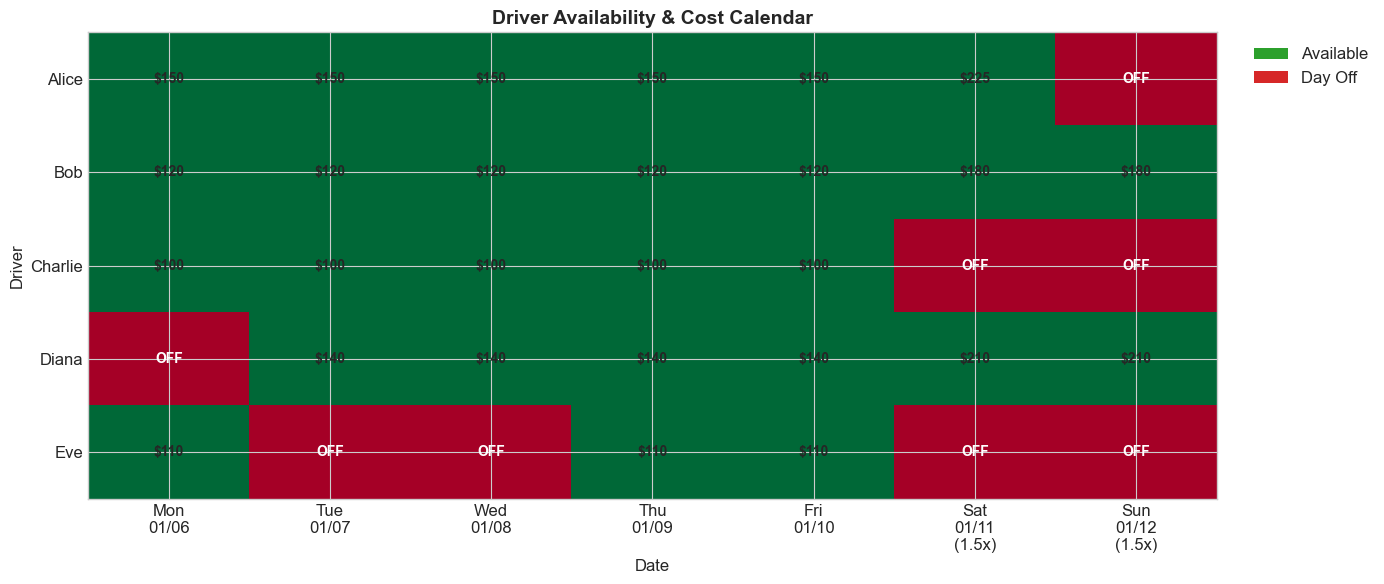

In [4]:
# Visualize driver availability calendar
fig, ax = plt.subplots(figsize=(14, 6))

active_drivers = [d for d in DRIVERS if d.is_active]
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Create availability matrix
availability_matrix = np.zeros((len(active_drivers), 7))
cost_matrix = np.zeros((len(active_drivers), 7))

for i, driver in enumerate(active_drivers):
    for j, date in enumerate(DATES):
        if is_driver_available(driver, date):
            availability_matrix[i, j] = 1
            cost_matrix[i, j] = calculate_cost(driver, date)

# Create heatmap with custom colors
cmap = plt.cm.RdYlGn
im = ax.imshow(availability_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=1)

# Add cost labels
for i in range(len(active_drivers)):
    for j in range(7):
        if availability_matrix[i, j] == 1:
            ax.text(j, i, f'${cost_matrix[i, j]:.0f}', ha='center', va='center', fontsize=10, fontweight='bold')
        else:
            ax.text(j, i, 'OFF', ha='center', va='center', fontsize=10, color='white', fontweight='bold')

# Labels
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(len(active_drivers)))
date_labels = [f"{d.date.strftime('%a')}\n{d.date.strftime('%m/%d')}" + ('\n(1.5x)' if d.is_weekend else '') for d in DATES]
ax.set_xticklabels(date_labels)
ax.set_yticklabels([d.name for d in active_drivers])

ax.set_title('Driver Availability & Cost Calendar', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Driver')

# Add colorbar legend
legend_elements = [
    mpatches.Patch(facecolor='#2ca02c', label='Available'),
    mpatches.Patch(facecolor='#d62728', label='Day Off')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

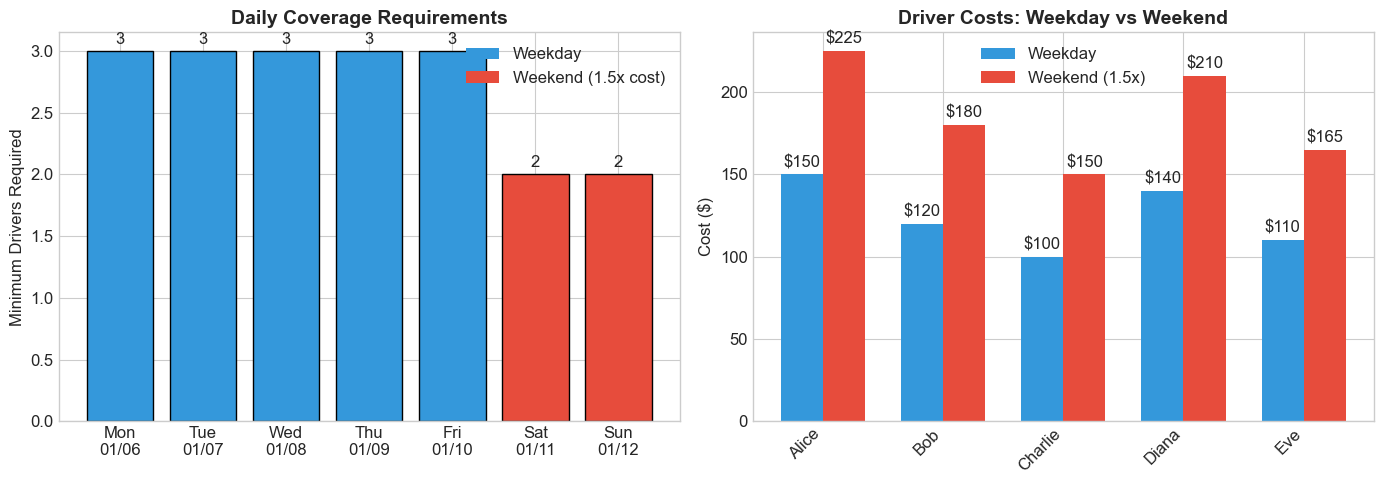

In [5]:
# Coverage requirements visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Daily requirements
ax1 = axes[0]
requirements = [d.min_drivers_required for d in DATES]
colors = ['#e74c3c' if d.is_weekend else '#3498db' for d in DATES]
bars = ax1.bar(range(7), requirements, color=colors, edgecolor='black')
ax1.set_xticks(range(7))
ax1.set_xticklabels([d.date.strftime('%a\n%m/%d') for d in DATES])
ax1.set_ylabel('Minimum Drivers Required')
ax1.set_title('Daily Coverage Requirements', fontsize=14, fontweight='bold')
ax1.bar_label(bars, padding=3)

legend_elements = [
    mpatches.Patch(facecolor='#3498db', label='Weekday'),
    mpatches.Patch(facecolor='#e74c3c', label='Weekend (1.5x cost)')
]
ax1.legend(handles=legend_elements)

# Driver cost comparison
ax2 = axes[1]
active_drivers = [d for d in DRIVERS if d.is_active]
x = np.arange(len(active_drivers))
width = 0.35

weekday_costs = [d.daily_rate for d in active_drivers]
weekend_costs = [d.daily_rate * 1.5 for d in active_drivers]

bars1 = ax2.bar(x - width/2, weekday_costs, width, label='Weekday', color='#3498db')
bars2 = ax2.bar(x + width/2, weekend_costs, width, label='Weekend (1.5x)', color='#e74c3c')

ax2.set_ylabel('Cost ($)')
ax2.set_title('Driver Costs: Weekday vs Weekend', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([d.name for d in active_drivers], rotation=45, ha='right')
ax2.legend()
ax2.bar_label(bars1, fmt='$%.0f', padding=3)
ax2.bar_label(bars2, fmt='$%.0f', padding=3)

plt.tight_layout()
plt.show()

## 3. Build the Optimization Model

This is where LumiX shines! We create a variable indexed by the **cartesian product** `(Driver × Date)`.

In [6]:
def build_scheduling_model() -> LXModel:
    """
    Build the driver scheduling optimization model.
    
    THE KEY FEATURE: Variables indexed by multiple models simultaneously!
    duty[driver, date] creates one binary variable for each valid combination.
    """
    
    # ========================================
    # MULTI-MODEL INDEXED VARIABLE
    # ========================================
    # This creates a binary variable for EACH (driver, date) combination!
    
    duty = (
        LXVariable[Tuple[Driver, Date], int]("duty")
        .binary()  # Binary: work (1) or not (0)
        .indexed_by_product(
            # First dimension: Driver
            LXIndexDimension(Driver, lambda d: d.id)
            .where(lambda d: d.is_active)  # Only active drivers
            .from_data(DRIVERS),
            # Second dimension: Date
            LXIndexDimension(Date, lambda dt: dt.date)
            .from_data(DATES),
        )
        # Cost function receives BOTH driver and date!
        .cost_multi(lambda driver, date: calculate_cost(driver, date))
        # Filter out invalid combinations
        .where_multi(lambda driver, date: is_driver_available(driver, date))
    )

    # Create model
    model = LXModel("driver_scheduling").add_variable(duty)

    # Objective: Minimize total cost
    cost_expr = LXLinearExpression().add_multi_term(
        duty, coeff=lambda driver, date: calculate_cost(driver, date)
    )
    model.minimize(cost_expr)

    # Constraint 1: Driver max days per week
    for driver in DRIVERS:
        if not driver.is_active:
            continue

        driver_days_expr = LXLinearExpression().add_multi_term(
            duty,
            coeff=lambda d, dt: 1.0,
            where=lambda d, dt, drv=driver: d.id == drv.id,
        )

        model.add_constraint(
            LXConstraint(f"max_days_{driver.name}")
            .expression(driver_days_expr)
            .le()
            .rhs(float(driver.max_days_per_week))
        )

    # Constraint 2: Daily coverage requirements
    for date in DATES:
        coverage_expr = LXLinearExpression().add_multi_term(
            duty,
            coeff=lambda d, dt: 1.0,
            where=lambda d, dt, current_date=date: dt.date == current_date.date,
        )

        model.add_constraint(
            LXConstraint(f"coverage_{date.date}")
            .expression(coverage_expr)
            .ge()
            .rhs(float(date.min_drivers_required))
        )

    return model


# Build the model
model = build_scheduling_model()

# Display model summary
print("Model Summary:")
print("=" * 50)
print(model.summary())

Model Summary:
LXModel: driver_scheduling
  Variable Families: 1
  Constraint Families: 12
  Objective: min



## 4. Solve the Model

In [7]:
# Create optimizer
optimizer = LXOptimizer().use_solver("ortools")

# Solve
print("Solving the driver scheduling problem...")
solution = optimizer.solve(model)

print(f"\nSolution Status: {solution.status}")
print(f"Optimal Cost: ${solution.objective_value:,.2f}")
print(f"Solve Time: {solution.solve_time:.3f}s")

2025-12-12 16:53:16 - lumix.optimizer - INFO - Created model 'driver_scheduling' with 1 variables and 12 constraints
2025-12-12 16:53:16 - lumix.optimizer - INFO - Starting solve with ortools...
2025-12-12 16:53:16 - lumix.optimizer - INFO - Solve completed: optimal | Objective: 2560.0000 | Time: 0.01s


Solving the driver scheduling problem...

Solution Status: optimal
Optimal Cost: $2,560.00
Solve Time: 0.002s


## 5. Analyze the Results

In [8]:
# Extract schedule matrix
active_drivers = [d for d in DRIVERS if d.is_active]
schedule_matrix = np.zeros((len(active_drivers), len(DATES)))
cost_matrix = np.zeros((len(active_drivers), len(DATES)))

for i, driver in enumerate(active_drivers):
    for j, date in enumerate(DATES):
        if is_driver_available(driver, date):
            value = solution.variables["duty"].get((driver.id, date.date), 0)
            if value > 0.5:
                schedule_matrix[i, j] = 1
                cost_matrix[i, j] = calculate_cost(driver, date)

# Create schedule summary
schedule_data = []
for driver in active_drivers:
    days_worked = []
    total_earnings = 0
    
    for date in DATES:
        if is_driver_available(driver, date):
            value = solution.variables["duty"].get((driver.id, date.date), 0)
            if value > 0.5:
                days_worked.append(date.date.strftime("%a"))
                total_earnings += calculate_cost(driver, date)
    
    schedule_data.append({
        'Driver': driver.name,
        'Days Worked': len(days_worked),
        'Max Allowed': driver.max_days_per_week,
        'Schedule': ', '.join(days_worked) if days_worked else 'Not scheduled',
        'Total Earnings ($)': total_earnings
    })

schedule_df = pd.DataFrame(schedule_data)

print("\n" + "=" * 70)
print("DRIVER SCHEDULE SUMMARY")
print("=" * 70)
display(schedule_df.set_index('Driver'))


DRIVER SCHEDULE SUMMARY


,Days Worked,Max Allowed,Schedule,Total Earnings ($)
Driver,,,,
Alice,1,5,Mon,150.0
Bob,6,6,"Mon, Tue, Wed, Thu, Sat, Sun",840.0
Charlie,4,4,"Tue, Wed, Thu, Fri",400.0
Diana,5,5,"Tue, Wed, Fri, Sat, Sun",840.0
Eve,3,3,"Mon, Thu, Fri",330.0


In [9]:
# Daily coverage summary
daily_data = []

for date in DATES:
    drivers_assigned = []
    daily_cost = 0
    
    for driver in active_drivers:
        if is_driver_available(driver, date):
            value = solution.variables["duty"].get((driver.id, date.date), 0)
            if value > 0.5:
                drivers_assigned.append(driver.name)
                daily_cost += calculate_cost(driver, date)
    
    daily_data.append({
        'Date': date.date.strftime('%a %m/%d'),
        'Required': date.min_drivers_required,
        'Assigned': len(drivers_assigned),
        'Drivers': ', '.join(drivers_assigned),
        'Daily Cost ($)': daily_cost,
        'Type': 'Weekend' if date.is_weekend else 'Weekday'
    })

daily_df = pd.DataFrame(daily_data)

print("\n" + "=" * 70)
print("DAILY COVERAGE")
print("=" * 70)
display(daily_df.set_index('Date'))


DAILY COVERAGE


,Required,Assigned,Drivers,Daily Cost ($),Type
Date,,,,,
Mon 01/06,3,3,"Alice, Bob, Eve",380.0,Weekday
Tue 01/07,3,3,"Bob, Charlie, Diana",360.0,Weekday
Wed 01/08,3,3,"Bob, Charlie, Diana",360.0,Weekday
Thu 01/09,3,3,"Bob, Charlie, Eve",330.0,Weekday
Fri 01/10,3,3,"Charlie, Diana, Eve",350.0,Weekday
Sat 01/11,2,2,"Bob, Diana",390.0,Weekend
Sun 01/12,2,2,"Bob, Diana",390.0,Weekend


## 6. Visualize the Optimal Schedule

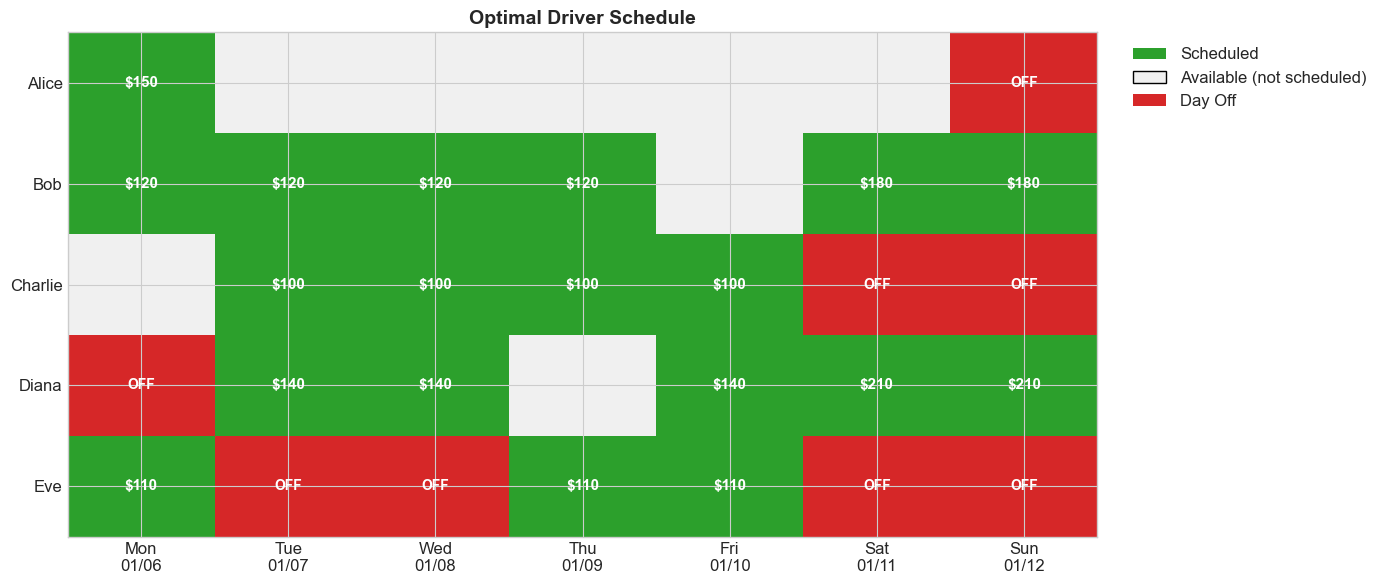

In [10]:
# Schedule heatmap (Gantt-style)
fig, ax = plt.subplots(figsize=(14, 6))

# Create custom colormap: white (not scheduled), green (scheduled), gray (unavailable)
schedule_display = np.zeros((len(active_drivers), 7))
for i, driver in enumerate(active_drivers):
    for j, date in enumerate(DATES):
        if not is_driver_available(driver, date):
            schedule_display[i, j] = -1  # Unavailable
        elif schedule_matrix[i, j] == 1:
            schedule_display[i, j] = 1   # Scheduled
        else:
            schedule_display[i, j] = 0   # Available but not scheduled

# Custom colormap
from matplotlib.colors import ListedColormap
colors_list = ['#d62728', '#f0f0f0', '#2ca02c']  # Red (off), Light gray (not scheduled), Green (scheduled)
cmap = ListedColormap(colors_list)

im = ax.imshow(schedule_display, cmap=cmap, aspect='auto', vmin=-1, vmax=1)

# Add cost labels for scheduled shifts
for i in range(len(active_drivers)):
    for j in range(7):
        if schedule_display[i, j] == 1:
            ax.text(j, i, f'${cost_matrix[i, j]:.0f}', ha='center', va='center', 
                    fontsize=11, fontweight='bold', color='white')
        elif schedule_display[i, j] == -1:
            ax.text(j, i, 'OFF', ha='center', va='center', 
                    fontsize=10, fontweight='bold', color='white')

# Labels
ax.set_xticks(np.arange(7))
ax.set_yticks(np.arange(len(active_drivers)))
date_labels = [f"{d.date.strftime('%a')}\n{d.date.strftime('%m/%d')}" for d in DATES]
ax.set_xticklabels(date_labels)
ax.set_yticklabels([d.name for d in active_drivers])

ax.set_title('Optimal Driver Schedule', fontsize=14, fontweight='bold')

# Legend
legend_elements = [
    mpatches.Patch(facecolor='#2ca02c', label='Scheduled'),
    mpatches.Patch(facecolor='#f0f0f0', edgecolor='black', label='Available (not scheduled)'),
    mpatches.Patch(facecolor='#d62728', label='Day Off')
]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

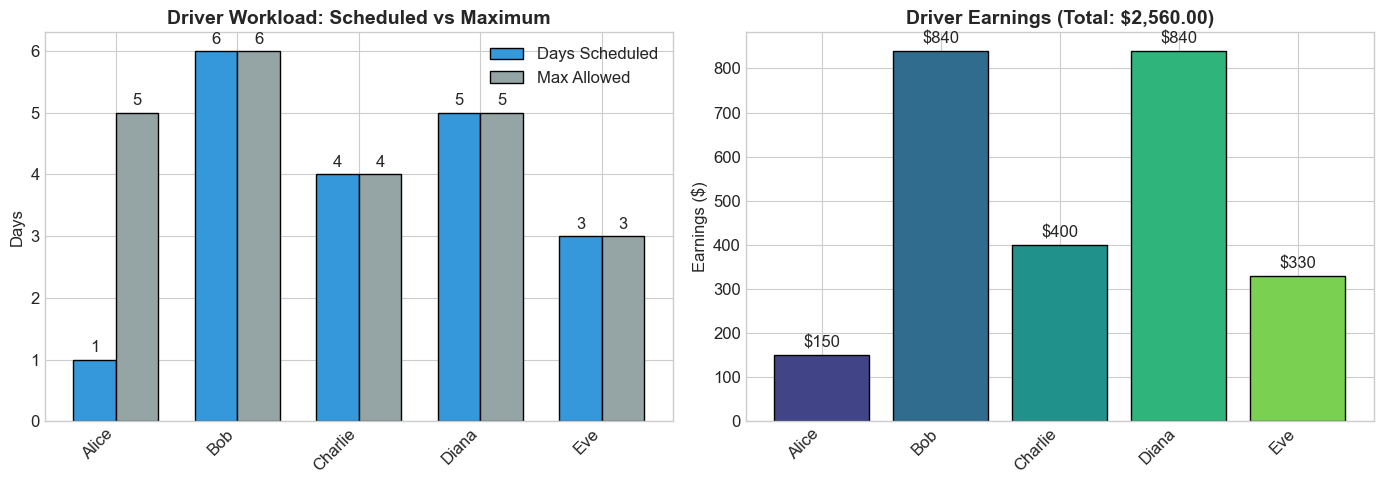

In [11]:
# Workload distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Driver workload
ax1 = axes[0]
drivers_names = schedule_df['Driver'].values
days_worked = schedule_df['Days Worked'].values
max_days = schedule_df['Max Allowed'].values

x = np.arange(len(drivers_names))
width = 0.35

bars1 = ax1.bar(x - width/2, days_worked, width, label='Days Scheduled', color='#3498db', edgecolor='black')
bars2 = ax1.bar(x + width/2, max_days, width, label='Max Allowed', color='#95a5a6', edgecolor='black')

ax1.set_ylabel('Days')
ax1.set_title('Driver Workload: Scheduled vs Maximum', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(drivers_names, rotation=45, ha='right')
ax1.legend()
ax1.bar_label(bars1, padding=3)
ax1.bar_label(bars2, padding=3)

# Earnings by driver
ax2 = axes[1]
earnings = schedule_df['Total Earnings ($)'].values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(earnings)))

bars = ax2.bar(drivers_names, earnings, color=colors, edgecolor='black')
ax2.set_ylabel('Earnings ($)')
ax2.set_title(f'Driver Earnings (Total: ${sum(earnings):,.2f})', fontsize=14, fontweight='bold')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
ax2.bar_label(bars, fmt='$%.0f', padding=3)

plt.tight_layout()
plt.show()

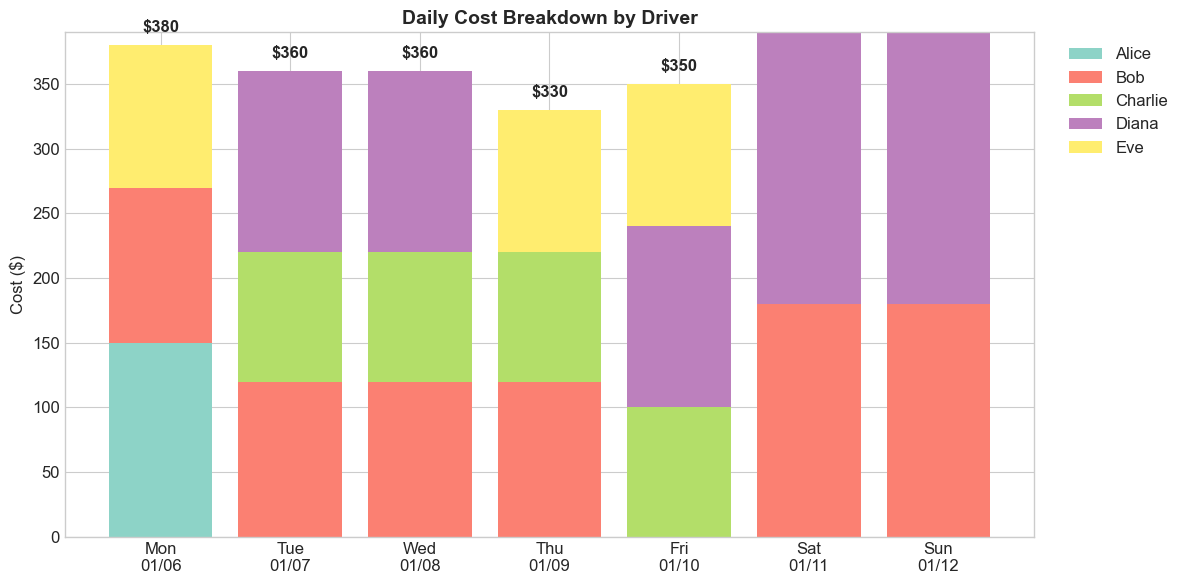

In [12]:
# Daily cost breakdown
fig, ax = plt.subplots(figsize=(12, 6))

# Stack costs by driver for each day
driver_colors = plt.cm.Set3(np.linspace(0, 1, len(active_drivers)))

bottom = np.zeros(7)
for i, driver in enumerate(active_drivers):
    driver_costs = cost_matrix[i, :]
    ax.bar(range(7), driver_costs, bottom=bottom, label=driver.name, color=driver_colors[i])
    bottom += driver_costs

ax.set_xticks(range(7))
ax.set_xticklabels([d.date.strftime('%a\n%m/%d') for d in DATES])
ax.set_ylabel('Cost ($)')
ax.set_title('Daily Cost Breakdown by Driver', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Add total cost labels
for j, total in enumerate(bottom):
    if total > 0:
        ax.annotate(f'${total:.0f}', (j, total + 10), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Key Insights

### Why Multi-Model Indexing Matters

**Traditional approach (other libraries):**
```python
# Manual index management - error-prone!
duty[0][1] = 1  # Which driver? Which date? IDE doesn't know!
```

**LumiX approach:**
```python
# Type-safe, data-driven indexing
duty = LXVariable[Tuple[Driver, Date], int]("duty")
    .indexed_by_product(
        LXIndexDimension(Driver, lambda d: d.id).from_data(DRIVERS),
        LXIndexDimension(Date, lambda dt: dt.date).from_data(DATES)
    )

# Access: solution.variables["duty"][(driver.id, date.date)]
```

### Benefits:
1. **Type safety**: IDE knows the structure
2. **Data-driven**: Variables expand automatically from data
3. **Filtering**: `where_multi()` excludes invalid combinations
4. **Cost functions**: `cost_multi()` receives both models
5. **Natural constraints**: Sum over specific dimensions easily

## 8. Extensions & Exercises

Try modifying this notebook:

1. **Add preference constraints**: Give drivers preferred days
2. **Consecutive days limit**: Max 3 consecutive working days
3. **Skill requirements**: Some dates need specific driver skills
4. **Shift types**: Morning vs evening shifts
5. **Fairness constraint**: Balanced workload across drivers